In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os, sys
sys.path.append('/home/hrai/codes/hpe_library')
#os.chdir('/home/hrai/codes/hpe_library')
from lib_import import *
from my_utils import *

# 주요 디렉토리 경로
user = getpass.getuser()
alphapose_root = '/home/{}/codes/AlphaPose'.format(user)
motionbert_root = '/home/{}/codes/MotionBERT'.format(user)
kookmin_root = '/home/{}/Datasets/HAAI/국민대데이터/data'.format(user)
ap_kookmin_result_root = alphapose_root + "/examples/kookmin_result_5actions"

assert os.path.isdir(alphapose_root), "AlphaPose root directory is not exist"
assert os.path.isdir(motionbert_root), "MotionBERT root directory is not exist"
#assert os.path.isdir(kookmin_root), "Kookmin root directory is not exist"
#assert os.path.isdir(ap_kookmin_result_root), "AlphaPose Kookmin result directory is not exist"

os.chdir(motionbert_root)
from lib.utils.tools import * # get_config
from lib.utils.learning import * # load_backbone
from lib.model.loss import *
from lib.data.datareader_kookmin import DataReaderKOOKMIN
from lib.data.datareader_h36m import DataReaderH36M
from lib.data.dataset_motion_3d import MotionDataset3D
#from lib.model.DHDSTformer import DHDSTformer, DHDSTformer2, DHDSTformer3, DHDSTformer_limb, DHDSTformer_torso

def parse_args(target):
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/pose3d/DHDST_kookmin_baseline.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-p', '--pretrained', default='checkpoint', type=str, metavar='PATH', help='pretrained checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='checkpoint/pose3d/MB_ft_h36m/best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-ms', '--selection', default='best_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to finetune (file name)')
    parser.add_argument('-sd', '--seed', default=0, type=int, help='random seed')
    parser.add_argument('-g', '--gpu', default='0', type=str, help='GPU id')
    #opts = parser.parse_args([])
    opts = parser.parse_args([
        '--config', 'configs/pose3d/{}.yaml'.format(target),
        '--evaluate', 'checkpoint/pose3d/{}/best_epoch.bin'.format(target)])
    return opts

def get_h36m_camera_info(subject, action, camera_id):
    cam_info = h36m_3d_world._data[subject][action]['cameras']
    cam_param = get_cam_param(cam_info, subject, h36m_cam_param)
    calibration_matrix = np.array(cam_param[camera_id]['int']['calibration_matrix'])
    R = np.array(cam_param[camera_id]['ext']['R'])
    t = np.array(cam_param[camera_id]['ext']['t'])/1000
    H = cam_param[camera_id]['H']
    W = cam_param[camera_id]['W']
    camera_param = {
        'intrinsic': calibration_matrix,
        'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
    }
    fx = camera_param['intrinsic'][0, 0]  
    fy = camera_param['intrinsic'][1, 1]  
    cx = camera_param['intrinsic'][0, 2]  
    cy = camera_param['intrinsic'][1, 2] 
    return calibration_matrix, camera_param, H, W, fx, fy, cx, cy

def data_processing(pose3d_list, camera_param, fx, fy, cx, cy, length=243):
    pose_2d_list = []
    cam_3d_list = []
    img_3d_list = []
    img_3d_hat_list = []
    img_25d_list = []
    scale_list = []
    for frame_num in range(len(pose3d_list[:length])):
        world_3d = np.array(pose3d_list[frame_num])
        # world to camera
        pos = copy.deepcopy(world_3d)
        cam_3d = World2CameraCoordinate(pos, camera_param['extrinsic']) * 1000 # World coordinate -> Camera coordinate
        cam_3d_hat = get_rootrel_pose(cam_3d)

        # camera to image
        box = infer_box(cam_3d, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0)
        img_2d, img_3d = camera_to_image_frame(cam_3d, box, {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}, 0) 
        img_3d_hat = get_rootrel_pose(img_3d) # (17, 3) # root-relative pose 
        # 2.5d factor
        pred_lambda, losses = optimize_scaling_factor(img_3d_hat, cam_3d_hat, stop_tolerance=0.0001) # x,y,z 사용
        # joint 2.5d image
        img_25d = img_3d * pred_lambda

        pose_2d_list.append(img_2d)
        cam_3d_list.append(cam_3d)
        img_3d_list.append(img_3d)
        img_3d_hat_list.append(img_3d_hat)
        img_25d_list.append(img_25d)
        scale_list.append(pred_lambda)

    pose_2d_list = np.array(pose_2d_list)
    pose_2d_list = np.append(pose_2d_list, np.ones((pose_2d_list.shape[0], pose_2d_list.shape[1], 1)), axis=2)
    cam_3d_list = np.array(cam_3d_list)
    img_3d_list = np.array(img_3d_list)
    img_3d_hat_list = np.array(img_3d_hat_list)
    img_25d_list = np.array(img_25d_list)
    scale_list = np.array(scale_list)

    return pose_2d_list, cam_3d_list, img_3d_list, img_3d_hat_list, img_25d_list, scale_list

def get_custom_camera_info(camera):
    calibration_matrix = camera.intrinsic
    R = camera.R
    t = camera.t/1000
    H = camera.IMAGE_HEIGHT
    W = camera.IMAGE_WIDTH
    camera_param = {
        'intrinsic': calibration_matrix,
        'extrinsic': np.concatenate([R, t.reshape(3, 1)], axis=1),
    }
    fx = camera_param['intrinsic'][0, 0]  
    fy = camera_param['intrinsic'][1, 1]  
    cx = camera_param['intrinsic'][0, 2]  
    cy = camera_param['intrinsic'][1, 2] 
    return calibration_matrix, camera_param, H, W, fx, fy, cx, cy

def mpjpe(predicted, target):
    """
    Mean per-joint position error (i.e. mean Euclidean distance),
    often referred to as "Protocol #1" in many papers.
    """
    assert predicted.shape == target.shape
    return np.mean(np.linalg.norm(predicted - target, axis=len(target.shape)-1), axis=1)

#### Load H36M Dataset

In [2]:
h36m_3d_world, h36m_cam_param = load_h36m()

==> Loading 3D data wrt World CS...


In [6]:
subject = 'S5'
action = 'Walking 1'
camera_id = '54138969'
length = 1000
target_video = f'{subject}_{action}_{camera_id}'

pose3d_list = h36m_3d_world._data[subject][action]['positions'].copy()
calibration_matrix, camera_param, H, W, fx, fy, cx, cy = get_h36m_camera_info(subject, action, camera_id)

pose_2d_list, cam_3d_list, img_3d_list, img_3d_hat_list, img_25d_list, scale_list = data_processing(pose3d_list.copy(), camera_param, fx, fy, cx, cy, length=length)
pose_2d_list = normalize_input(pose_2d_list, 1000, 1000)
pose_2d_list = torch.tensor(pose_2d_list).cuda().unsqueeze(0)
cam_3d_list = torch.tensor(cam_3d_list).cuda().unsqueeze(0)
img_3d_list = torch.tensor(img_3d_list).cuda().unsqueeze(0)
img_3d_hat_list = torch.tensor(img_3d_hat_list).cuda().unsqueeze(0)
img_25d_list = torch.tensor(img_25d_list).cuda().unsqueeze(0)

In [7]:
pose_2d_list.shape

torch.Size([1, 1000, 17, 3])

In [9]:
# original
batch_input = pose_2d_list.clone()[:, :, :, :2]
# root centered
root_centered = batch_input.clone() - batch_input[:, :, 0:1]
# scaled by euclidean
scaled_by_frobenius = batch_input.clone()
print(scaled_by_frobenius.shape)
scaled_by_frobenius_denormalized = batch_input.clone()
scaled_by_frobenius_denormalized[:, :, :, :2] = (scaled_by_frobenius_denormalized[:, :, :, :2] + torch.tensor([1, 1]).cuda()) * 1000 / 2
scaled_by_frobenius = scaled_by_frobenius - scaled_by_frobenius[:, :, 0:1]
print(scaled_by_frobenius.shape)
scaled_by_frobenius_denormalized = scaled_by_frobenius - scaled_by_frobenius[:, :, 0:1]
print(scaled_by_frobenius.reshape(-1, 34).shape)
scale = torch.norm(scaled_by_frobenius.reshape(-1, 34), dim=1, keepdim=True)
print(scale.shape)
scale_denormalized = torch.norm(scaled_by_frobenius_denormalized.reshape(-1, 34), dim=1, keepdim=True)
scaled_by_frobenius = (scaled_by_frobenius.reshape(-1, 34) / scale).reshape(1, -1, 17, 2)
scaled_by_frobenius_denormalized = (scaled_by_frobenius_denormalized.reshape(-1, 34) / scale).reshape(1, -1, 17, 2)
# scaled by each height
batch_height = root_centered[:, :, :, 1].max(dim=-1).values - root_centered[:, :, :, 1].min(dim=-1).values
batch_ratio = torch.ones_like(batch_height) / batch_height
scaled_by_each_height = root_centered.clone() * batch_ratio.unsqueeze(-1).unsqueeze(-1)
# scaled by first height
first_height = batch_height.max()
ratio = torch.ones_like(first_height) / first_height
scaled_by_fixed_height = root_centered.clone() * ratio.unsqueeze(-1).unsqueeze(-1)

original_input = batch_input.cpu().detach().numpy()
canonical_input1 = root_centered.clone().cpu().detach().numpy()
canonical_input2 = scaled_by_frobenius.clone().cpu().detach().numpy()
canonical_input3 = scaled_by_each_height.clone().cpu().detach().numpy()
canonical_input4 = scaled_by_fixed_height.clone().cpu().detach().numpy()
canonical_input5 = scaled_by_frobenius_denormalized.clone().cpu().detach().numpy()

height_original = get_pose_height(original_input)[0]
height_canonical1 = get_pose_height(canonical_input1)[0]
height_canonical2 = get_pose_height(canonical_input2)[0]
height_canonical3 = get_pose_height(canonical_input3)[0]
height_canonical4 = get_pose_height(canonical_input4)[0]

torch.Size([1, 1000, 17, 2])
torch.Size([1, 1000, 17, 2])
torch.Size([1000, 34])
torch.Size([1000, 1])


In [75]:
# target = 'MB_ft_h36m'

# opts = parse_args(target=target)
# args = get_config(opts.config)
# print(opts.evaluate)

# if 'DHDST2' in opts.evaluate:
#     model_pos = DHDSTformer2(chk_filename='', args=args)
# elif 'DHDST_torso' in opts.evaluate:
#     model_pos = DHDSTformer_torso(chk_filename='', args=args)
# elif 'DHDSTformer_limb' in opts.evaluate:
#     model_pos = DHDSTformer_limb(chk_filename='', args=args)
# elif 'MB' in opts.evaluate:
#     model_pos = load_backbone(args)
    
# model_pos = nn.DataParallel(model_pos)
# model_pos = model_pos.cuda()
# checkpoint = torch.load(opts.evaluate, map_location=lambda storage, loc: storage)
# model_pos.load_state_dict(checkpoint['model_pos'], strict=True)
# model_pos = model_pos.eval()

# args.dt_file = 'h36m_sh_conf_cam_source_final.pkl'
# args.subset_list = ['H36M-SH']
# datareader = DataReaderH36M(n_frames=args.clip_len, sample_stride=args.sample_stride, data_stride_train=args.data_stride, data_stride_test=args.clip_len, dt_root = 'data/motion3d', dt_file=args.dt_file)
# testloader_params = {
#         'batch_size': args.batch_size,
#         'shuffle': False,
#         'num_workers': 12,
#         'pin_memory': True,
#         'prefetch_factor': 4,
#         'persistent_workers': True
# }
# test_dataset = MotionDataset3D(args, args.subset_list, 'test')
# test_loader = DataLoader(test_dataset, **testloader_params)


In [76]:
# with torch.no_grad():
#     for batch_input, batch_gt in tqdm(test_loader):
#         if torch.cuda.is_available():
#             batch_input = batch_input.cuda()[:, :, :, :2]
#             batch_gt = batch_gt.cuda()
#         break

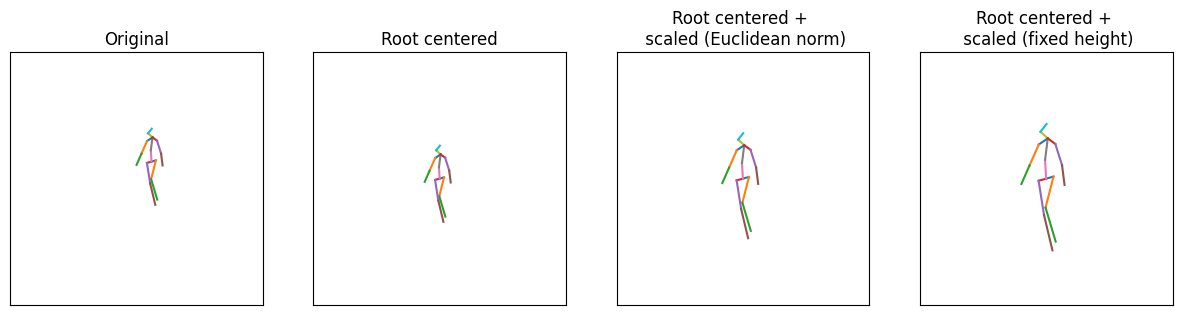

In [10]:
# visualize
batch_num = 0
frame_num = 150

%matplotlib inline
fig = plt.figure(0, figsize=(15, 5))
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABCD
    """,
    #per_subplot_kw={('A'): {'projection': '3d'}}
)

axA = axes_2d(ax=axd['A'], normalize=True, show_axis=False)
axB = axes_2d(ax=axd['B'], normalize=True, show_axis=False)
axC = axes_2d(ax=axd['C'], normalize=True, show_axis=False)
axD = axes_2d(ax=axd['D'], normalize=True, show_axis=False)
#axE = axes_2d(ax=axd['E'], normalize=True, show_axis=False)

axA.set_title('Original')
axB.set_title('Root centered')
axC.set_title('Root centered + \n scaled (Euclidean norm)')
axD.set_title('Root centered + \n scaled (fixed height)')

draw_2d_pose(axA, original_input[batch_num, frame_num], normalize=True)
draw_2d_pose(axB, canonical_input1[batch_num, frame_num], normalize=True)
draw_2d_pose(axC, canonical_input2[batch_num, frame_num], normalize=True)
draw_2d_pose(axD, canonical_input3[batch_num, frame_num], normalize=True)
plt.show()

In [25]:
len(pose_2d_list[0])

1000

100%|██████████| 1000/1000 [01:02<00:00, 15.94it/s]


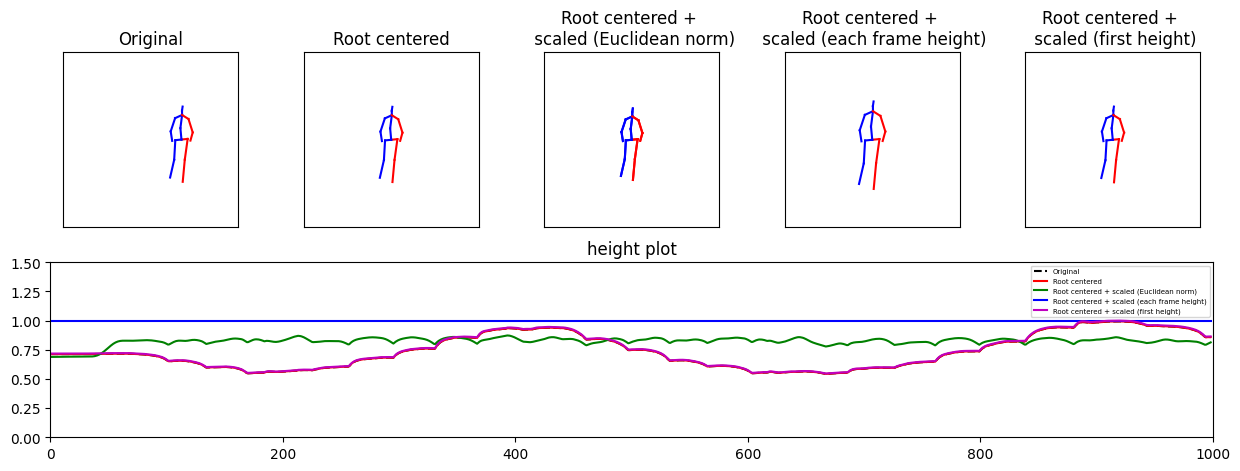

In [49]:
batch_num = 0

%matplotlib inline
fig = plt.figure(0, figsize=(15, 5))
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABCDE
    FFFFF
    """,
    #per_subplot_kw={('A'): {'projection': '3d'}}
)

axA = axes_2d(ax=axd['A'], normalize=True, show_axis=False)
axB = axes_2d(ax=axd['B'], normalize=True, show_axis=False)
axC = axes_2d(ax=axd['C'], normalize=True, show_axis=False)
axD = axes_2d(ax=axd['D'], normalize=True, show_axis=False)
axE = axes_2d(ax=axd['E'], normalize=True, show_axis=False)
axF = axd['F']
axF.set_xlim(0, len(pose_2d_list[0]))
axF.set_ylim(0, 1.5)


axA.set_title('Original')
axB.set_title('Root centered')
axC.set_title('Root centered + \n scaled (Euclidean norm)')
axD.set_title('Root centered + \n scaled (each frame height)')
axE.set_title('Root centered + \n scaled (first height)')
axF.set_title('height plot')

videowriter = imageio.get_writer(f'/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_input_type_{subject}_{action}_{camera_id}.mp4', fps=30)
for frame_num in tqdm(range(len(pose_2d_list[0]))):
    clear_axes([axA, axB, axC, axD, axE, axF])
    draw_2d_pose(axA, original_input[batch_num, frame_num], normalize=True)
    draw_2d_pose(axB, canonical_input1[batch_num, frame_num], normalize=True)
    draw_2d_pose(axC, canonical_input2[batch_num, frame_num], normalize=True)
    draw_2d_pose(axC, canonical_input5[batch_num, frame_num], normalize=True)
    draw_2d_pose(axD, canonical_input3[batch_num, frame_num], normalize=True)
    draw_2d_pose(axE, canonical_input4[batch_num, frame_num], normalize=True)

    axF.plot(height_original[:frame_num], 'k--', label='Original')
    axF.plot(height_canonical1[:frame_num], 'r', label='Root centered')
    axF.plot(height_canonical2[:frame_num], 'g', label='Root centered + scaled (Euclidean norm)')
    axF.plot(height_canonical3[:frame_num], 'b', label='Root centered + scaled (each frame height)')
    axF.plot(height_canonical4[:frame_num], 'm', label='Root centered + scaled (first height)')
    axF.legend(loc='upper right', fontsize=7)
    
    canvas = FigureCanvas(fig)
    canvas.draw()
    image_from_plot = np.array(canvas.renderer._renderer)
    image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
    videowriter.append_data(image_from_plot)
videowriter.close()

Waiting 1


  0%|          | 0/1440 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6a47900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1440/1440 [00:46<00:00, 31.20it/s]


Photo 1


  0%|          | 0/1074 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x55db900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1074/1074 [00:34<00:00, 31.15it/s]


Smoking


  0%|          | 0/2478 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x691f900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2478/2478 [01:25<00:00, 28.87it/s]


Eating 2


  0%|          | 0/2357 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6326900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2357/2357 [01:18<00:00, 30.21it/s]


WalkTogether 1


  0%|          | 0/1275 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5bcf900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1275/1275 [00:42<00:00, 30.04it/s]


Greeting 1


  0%|          | 0/1265 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6eaf900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1265/1265 [00:42<00:00, 30.06it/s]


Phoning


  0%|          | 0/2266 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7437900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2266/2266 [01:13<00:00, 30.73it/s]


Phoning 1


  0%|          | 0/2636 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x622a900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2636/2636 [01:24<00:00, 31.08it/s]


Smoking 1


  0%|          | 0/2611 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6fe1900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2611/2611 [01:25<00:00, 30.65it/s]


Discussion 1


  0%|          | 0/3805 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f72900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3805/3805 [02:05<00:00, 30.38it/s]


WalkTogether


  0%|          | 0/1231 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6d6a900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1231/1231 [00:39<00:00, 31.16it/s]


Sitting 1


  0%|          | 0/3304 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x67bc900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3304/3304 [01:48<00:00, 30.43it/s]


SittingDown


100%|██████████| 2742/2742 [01:30<00:00, 30.38it/s]


Directions


  0%|          | 0/1612 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5ff8900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1612/1612 [00:53<00:00, 30.31it/s]


Directions 1


  0%|          | 0/1383 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7209900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1383/1383 [00:45<00:00, 30.39it/s]


Purchases


  0%|          | 0/1158 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x60ed900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1158/1158 [00:37<00:00, 30.86it/s]


SittingDown 2


  0%|          | 0/3023 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f02900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3023/3023 [01:39<00:00, 30.39it/s]


Walking 1


  0%|          | 0/3476 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x572b900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3476/3476 [01:52<00:00, 31.00it/s]


WalkDog 1


  0%|          | 0/1662 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5dcf900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1662/1662 [00:54<00:00, 30.64it/s]


Waiting


  0%|          | 0/1792 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x67e3900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1792/1792 [00:59<00:00, 30.28it/s]


Walking


  0%|          | 0/3134 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5c65900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3134/3134 [01:41<00:00, 30.92it/s]


Discussion


  0%|          | 0/3852 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7216900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 3852/3852 [02:05<00:00, 30.78it/s]


Eating


100%|██████████| 2721/2721 [01:27<00:00, 31.08it/s]


Posing


100%|██████████| 992/992 [00:32<00:00, 30.27it/s]


Greeting


  0%|          | 0/1149 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5f36900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1149/1149 [00:37<00:00, 30.95it/s]


Posing 1


  0%|          | 0/1167 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6aa7900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1167/1167 [00:38<00:00, 30.45it/s]


WalkDog


  0%|          | 0/1777 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5648900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1777/1777 [00:58<00:00, 30.31it/s]


Photo


  0%|          | 0/1036 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5e28900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1036/1036 [00:34<00:00, 30.45it/s]


Purchases 1


  0%|          | 0/1064 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x734f900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 1064/1064 [00:34<00:00, 30.67it/s]


Sitting 2


  0%|          | 0/2612 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5f12900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 2612/2612 [01:24<00:00, 31.06it/s]


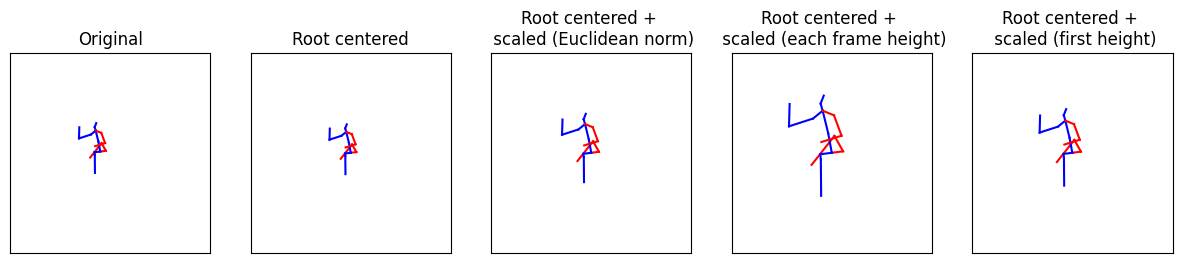

In [6]:
subject = 'S1'
for action in h36m_3d_world._data[subject].keys():
    print(action)
    camera_id = '54138969'
    
    target_video = f'{subject}_{action}_{camera_id}'

    pose3d_list = h36m_3d_world._data[subject][action]['positions'].copy()
    length = len(pose3d_list)
    calibration_matrix, camera_param, H, W, fx, fy, cx, cy = get_h36m_camera_info(subject, action, camera_id)

    pose_2d_list, cam_3d_list, img_3d_list, img_3d_hat_list, img_25d_list, scale_list = data_processing(pose3d_list.copy(), camera_param, fx, fy, cx, cy, length=length)
    pose_2d_list = normalize_input(pose_2d_list, 1000, 1000)
    pose_2d_list = torch.tensor(pose_2d_list).cuda().unsqueeze(0)
    cam_3d_list = torch.tensor(cam_3d_list).cuda().unsqueeze(0)
    img_3d_list = torch.tensor(img_3d_list).cuda().unsqueeze(0)
    img_3d_hat_list = torch.tensor(img_3d_hat_list).cuda().unsqueeze(0)
    img_25d_list = torch.tensor(img_25d_list).cuda().unsqueeze(0)

    # original
    batch_input = pose_2d_list.clone()[:, :, :, :2]
    # root centered
    root_centered = batch_input.clone() - batch_input[:, :, 0:1]
    # scaled by euclidean
    scaled_by_frobenius = batch_input.clone()
    scaled_by_frobenius_denormalized = batch_input.clone()
    scaled_by_frobenius_denormalized[:, :, :, :2] = (scaled_by_frobenius_denormalized[:, :, :, :2] + torch.tensor([1, 1]).cuda()) * 1000 / 2
    scaled_by_frobenius = scaled_by_frobenius - scaled_by_frobenius[:, :, 0:1]
    scaled_by_frobenius_denormalized = scaled_by_frobenius - scaled_by_frobenius[:, :, 0:1]
    scale = torch.norm(scaled_by_frobenius.reshape(-1, 34), dim=1, keepdim=True)
    scale_denormalized = torch.norm(scaled_by_frobenius_denormalized.reshape(-1, 34), dim=1, keepdim=True)
    scaled_by_frobenius = (scaled_by_frobenius.reshape(-1, 34) / scale).reshape(1, -1, 17, 2)
    scaled_by_frobenius_denormalized = (scaled_by_frobenius_denormalized.reshape(-1, 34) / scale).reshape(1, -1, 17, 2)
    # scaled by each height
    batch_height = root_centered[:, :, :, 1].max(dim=-1).values - root_centered[:, :, :, 1].min(dim=-1).values
    batch_ratio = torch.ones_like(batch_height) / batch_height
    scaled_by_each_height = root_centered.clone() * batch_ratio.unsqueeze(-1).unsqueeze(-1)
    # scaled by first height
    first_height = batch_height.max()
    ratio = torch.ones_like(first_height) / first_height
    scaled_by_fixed_height = root_centered.clone() * ratio.unsqueeze(-1).unsqueeze(-1)

    original_input = batch_input.cpu().detach().numpy()
    canonical_input1 = root_centered.clone().cpu().detach().numpy()
    canonical_input2 = scaled_by_frobenius.clone().cpu().detach().numpy()
    canonical_input3 = scaled_by_each_height.clone().cpu().detach().numpy()
    canonical_input4 = scaled_by_fixed_height.clone().cpu().detach().numpy()
    canonical_input5 = scaled_by_frobenius_denormalized.clone().cpu().detach().numpy()

    height_original = get_pose_height(original_input)[0]
    height_canonical1 = get_pose_height(canonical_input1)[0]
    height_canonical2 = get_pose_height(canonical_input2)[0]
    height_canonical3 = get_pose_height(canonical_input3)[0]
    height_canonical4 = get_pose_height(canonical_input4)[0]

    # save video
    batch_num = 0

    %matplotlib inline
    fig = plt.figure(0, figsize=(15, 5))
    fig.clear()
    axd = fig.subplot_mosaic(
        """
        ABCDE
        FFFFF
        """,
        #per_subplot_kw={('A'): {'projection': '3d'}}
    )

    axA = axes_2d(ax=axd['A'], normalize=True, show_axis=False)
    axB = axes_2d(ax=axd['B'], normalize=True, show_axis=False)
    axC = axes_2d(ax=axd['C'], normalize=True, show_axis=False)
    axD = axes_2d(ax=axd['D'], normalize=True, show_axis=False)
    axE = axes_2d(ax=axd['E'], normalize=True, show_axis=False)
    axF = axd['F']
    axF.set_xlim(0, len(pose_2d_list[0]))
    axF.set_ylim(0, 1.5)

    axA.set_title('Original')
    axB.set_title('Root centered')
    axC.set_title('Root centered + \n scaled (Euclidean norm)')
    axD.set_title('Root centered + \n scaled (each frame height)')
    axE.set_title('Root centered + \n scaled (first height)')
    axF.set_title('height plot')

    videowriter = imageio.get_writer(f'/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_input_type_{subject}_{action}_{camera_id}.mp4', fps=30)
    for frame_num in tqdm(range(length)):
        clear_axes([axA, axB, axC, axD, axE, axF])
        draw_2d_pose(axA, original_input[batch_num, frame_num], normalize=True)
        draw_2d_pose(axB, canonical_input1[batch_num, frame_num], normalize=True)
        draw_2d_pose(axC, canonical_input2[batch_num, frame_num], normalize=True)
        draw_2d_pose(axD, canonical_input3[batch_num, frame_num], normalize=True)
        draw_2d_pose(axE, canonical_input4[batch_num, frame_num], normalize=True)

        axF.plot(height_original[:frame_num], 'k--', label='Original')
        axF.plot(height_canonical1[:frame_num], 'r', label='Root centered')
        axF.plot(height_canonical2[:frame_num], 'g', label='Root centered + scaled (Euclidean norm)')
        axF.plot(height_canonical3[:frame_num], 'b', label='Root centered + scaled (each frame height)')
        axF.plot(height_canonical4[:frame_num], 'm', label='Root centered + scaled (first height)')
        axF.legend(loc='upper right', fontsize=7)
        
        canvas = FigureCanvas(fig)
        canvas.draw()
        image_from_plot = np.array(canvas.renderer._renderer)
        image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
        videowriter.append_data(image_from_plot)
    videowriter.close()

/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Walking.pkl
S1 Walking 54138969


  0%|          | 0/627 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5831900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 627/627 [00:36<00:00, 17.31it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_WalkTogether 1.pkl
S7 WalkTogether 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Photo 1.pkl
S9 Photo 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Waiting.pkl
S11 Waiting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Directions.pkl
S1 Directions 58860488


  0%|          | 0/323 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6169900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 323/323 [00:18<00:00, 17.32it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Posing 1.pkl
S11 Posing 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_SittingDown 1.pkl
S11 SittingDown 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Smoking.pkl
S7 Smoking 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_WalkTogether.pkl
S5 WalkTogether 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Phoning.pkl
S1 Phoning 58860488


  0%|          | 0/454 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x706a900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 454/454 [00:26<00:00, 17.00it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Purchases 1.pkl
S8 Purchases 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Photo 1.pkl
S8 Photo 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Discussion 1.pkl
S6 Discussion 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Eating 1.pkl
S6 Eating 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Sitting 1.pkl
S11 Sitting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Smoking.pkl
S1 Smoking 58860488


  0%|          | 0/496 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x740d900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 496/496 [00:28<00:00, 17.19it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Greeting 1.pkl
S9 Greeting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Discussion 2.pkl
S5 Discussion 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Sitting 2.pkl
S1 Sitting 2 58860488


  0%|          | 0/523 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6266900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 523/523 [00:30<00:00, 17.06it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_SittingDown 2.pkl
S1 SittingDown 2 58860488


  0%|          | 0/605 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x73e4900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 605/605 [00:35<00:00, 17.06it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Sitting.pkl
S9 Sitting 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Photo.pkl
S6 Photo 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Directions.pkl
S9 Directions 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Walking 1.pkl
S1 Walking 1 60457274


  0%|          | 0/696 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x70d7900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 696/696 [00:40<00:00, 17.32it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Waiting.pkl
S9 Waiting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Waiting 3.pkl
S6 Waiting 3 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_WalkDog 1.pkl
S6 WalkDog 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_WalkDog.pkl
S11 WalkDog 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Posing 1.pkl
S9 Posing 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Sitting.pkl
S8 Sitting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Waiting 1.pkl
S5 Waiting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Sitting 1.pkl
S8 Sitting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_WalkTogether.pkl
S7 WalkTogether 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_WalkDog 1.pkl
S1 WalkD

  0%|          | 0/333 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x72da900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 333/333 [00:19<00:00, 16.69it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Waiting 3.pkl
S6 Waiting 3 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Discussion.pkl
S1 Discussion 58860488


  0%|          | 0/771 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5a06900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 771/771 [00:45<00:00, 17.11it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Purchases.pkl
S1 Purchases 55011271


  0%|          | 0/232 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x73e2900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 232/232 [00:13<00:00, 16.80it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Greeting 1.pkl
S8 Greeting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Sitting 1.pkl
S7 Sitting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Phoning 1.pkl
S8 Phoning 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Sitting 2.pkl
S1 Sitting 2 55011271


  0%|          | 0/523 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x65d6900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 523/523 [00:30<00:00, 17.10it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Waiting.pkl
S8 Waiting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Photo.pkl
S1 Photo 55011271


  0%|          | 0/208 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6c03900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 208/208 [00:12<00:00, 17.08it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Posing 1.pkl
S11 Posing 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_WalkTogether 1.pkl
S6 WalkTogether 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_WalkDog 1.pkl
S5 WalkDog 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Walking.pkl
S6 Walking 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Phoning.pkl
S7 Phoning 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Posing 2.pkl
S6 Posing 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_WalkDog 1.pkl
S9 WalkDog 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_SittingDown.pkl
S5 SittingDown 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_SittingDown 1.pkl
S8 SittingDown 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Wal

  0%|          | 0/528 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5ec8900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 528/528 [00:31<00:00, 17.00it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Directions 1.pkl
S8 Directions 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Sitting 1.pkl
S1 Sitting 1 54138969


  0%|          | 0/661 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x61b5900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 661/661 [00:38<00:00, 17.29it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Directions.pkl
S8 Directions 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Posing 1.pkl
S1 Posing 1 54138969


  0%|          | 0/234 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x56fa900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 234/234 [00:13<00:00, 17.26it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Smoking 1.pkl
S5 Smoking 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Posing.pkl
S7 Posing 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Posing.pkl
S11 Posing 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Sitting.pkl
S8 Sitting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_SittingDown.pkl
S5 SittingDown 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Smoking.pkl
S5 Smoking 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Walking.pkl
S5 Walking 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Sitting.pkl
S9 Sitting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Phoning 1.pkl
S5 Phoning 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_WalkTogether 1.pkl
S7 WalkTogether 1 5

  0%|          | 0/255 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5b2b900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 255/255 [00:14<00:00, 17.26it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Eating 1.pkl
S9 Eating 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Greeting 1.pkl
S7 Greeting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Directions 1.pkl
S9 Directions 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Posing 1.pkl
S1 Posing 1 55011271


  0%|          | 0/234 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6e9b900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 234/234 [00:13<00:00, 17.03it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Photo.pkl
S6 Photo 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Photo.pkl
S1 Photo 58860488


  0%|          | 0/208 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x581b900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 208/208 [00:12<00:00, 16.98it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_WalkDog 1.pkl
S1 WalkDog 1 54138969


  0%|          | 0/333 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x71ff900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 333/333 [00:19<00:00, 17.18it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Posing 1.pkl
S8 Posing 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Smoking 1.pkl
S1 Smoking 1 58860488


  0%|          | 0/523 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5964900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 523/523 [00:30<00:00, 17.29it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Greeting 1.pkl
S1 Greeting 1 58860488


100%|██████████| 253/253 [00:15<00:00, 16.81it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_SittingDown.pkl
S6 SittingDown 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Greeting 2.pkl
S5 Greeting 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Directions 1.pkl
S5 Directions 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Photo.pkl
S5 Photo 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Smoking.pkl
S6 Smoking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Walking.pkl
S1 Walking 58860488


  0%|          | 0/627 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5d16900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 627/627 [00:36<00:00, 17.05it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Posing.pkl
S8 Posing 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Waiting 2.pkl
S5 Waiting 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Purchases.pkl
S6 Purchases 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Eating.pkl
S9 Eating 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Purchases.pkl
S6 Purchases 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Discussion.pkl
S7 Discussion 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_WalkTogether 1.pkl
S8 WalkTogether 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Eating.pkl
S8 Eating 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Directions.pkl
S7 Directions 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Greeting 1.pkl
S7 Gr

  0%|          | 0/523 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x61d5900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 523/523 [00:30<00:00, 17.05it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Waiting 1.pkl
S8 Waiting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Phoning.pkl
S7 Phoning 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Sitting 2.pkl
S6 Sitting 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Photo 1.pkl
S1 Photo 1 55011271


  0%|          | 0/215 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x704e900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 215/215 [00:12<00:00, 16.98it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Directions.pkl
S6 Directions 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Phoning 1.pkl
S9 Phoning 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Eating.pkl
S9 Eating 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Greeting 1.pkl
S8 Greeting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Smoking 1.pkl
S6 Smoking 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Phoning 3.pkl
S11 Phoning 3 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Directions 1.pkl
S7 Directions 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Purchases 1.pkl
S1 Purchases 1 58860488


  0%|          | 0/213 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6985900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 213/213 [00:12<00:00, 17.16it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Eating.pkl
S7 Eating 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Greeting.pkl
S9 Greeting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Greeting.pkl
S8 Greeting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Waiting 2.pkl
S7 Waiting 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Phoning.pkl
S5 Phoning 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_WalkDog 1.pkl
S9 WalkDog 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Phoning.pkl
S1 Phoning 54138969


  0%|          | 0/454 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5986900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 454/454 [00:26<00:00, 17.09it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Directions 1.pkl
S9 Directions 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Photo 1.pkl
S8 Photo 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Sitting.pkl
S7 Sitting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Discussion.pkl
S1 Discussion 55011271


  0%|          | 0/771 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x591a900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 771/771 [00:45<00:00, 16.87it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Posing.pkl
S11 Posing 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Walking 1.pkl
S6 Walking 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Sitting 1.pkl
S6 Sitting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Walking 1.pkl
S5 Walking 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Walking.pkl
S9 Walking 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Smoking.pkl
S11 Smoking 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_WalkTogether.pkl
S11 WalkTogether 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Phoning 2.pkl
S11 Phoning 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Purchases.pkl
S8 Purchases 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Purchases.pkl
S6

  0%|          | 0/230 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5633900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 230/230 [00:13<00:00, 17.19it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Discussion 1.pkl
S6 Discussion 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Directions 1.pkl
S8 Directions 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Walking.pkl
S11 Walking 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Posing 1.pkl
S9 Posing 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Purchases.pkl
S5 Purchases 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Walking.pkl
S11 Walking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Eating 2.pkl
S6 Eating 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Waiting 1.pkl
S9 Waiting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Smoking.pkl
S8 Smoking 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Posing 1.pkl
S9 

  0%|          | 0/232 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6d02900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 232/232 [00:13<00:00, 17.03it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Smoking 1.pkl
S8 Smoking 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Smoking.pkl
S1 Smoking 60457274


  0%|          | 0/496 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x63bf900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 496/496 [00:29<00:00, 17.02it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Walking.pkl
S5 Walking 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Eating.pkl
S8 Eating 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Discussion 2.pkl
S9 Discussion 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Eating 2.pkl
S6 Eating 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_WalkDog.pkl
S5 WalkDog 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Discussion 3.pkl
S5 Discussion 3 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_WalkTogether.pkl
S6 WalkTogether 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Sitting.pkl
S5 Sitting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Walking 1.pkl
S11 Walking 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Directions.pkl
S

  0%|          | 0/549 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5850900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 549/549 [00:31<00:00, 17.27it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Waiting 2.pkl
S7 Waiting 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_WalkTogether 1.pkl
S11 WalkTogether 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_WalkTogether 2.pkl
S8 WalkTogether 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Discussion 2.pkl
S11 Discussion 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_WalkTogether 1.pkl
S6 WalkTogether 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_SittingDown 1.pkl
S9 SittingDown 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Waiting 3.pkl
S6 Waiting 3 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Walking 1.pkl
S1 Walking 1 58860488


  0%|          | 0/696 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5b21900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 696/696 [00:40<00:00, 17.26it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Greeting.pkl
S8 Greeting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Photo.pkl
S8 Photo 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Sitting 1.pkl
S11 Sitting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_WalkDog.pkl
S11 WalkDog 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Greeting 1.pkl
S8 Greeting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Waiting 1.pkl
S1 Waiting 1 60457274


  0%|          | 0/288 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x700b900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 288/288 [00:16<00:00, 17.28it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Photo.pkl
S11 Photo 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Walking 1.pkl
S8 Walking 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_WalkTogether.pkl
S1 WalkTogether 54138969


  0%|          | 0/247 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x67ca900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 247/247 [00:14<00:00, 17.25it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Waiting 2.pkl
S5 Waiting 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Sitting 2.pkl
S6 Sitting 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_WalkTogether 1.pkl
S1 WalkTogether 1 58860488


  0%|          | 0/255 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5bb6900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 255/255 [00:14<00:00, 17.12it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_SittingDown 1.pkl
S6 SittingDown 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Phoning.pkl
S6 Phoning 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_WalkDog.pkl
S6 WalkDog 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Walking 1.pkl
S11 Walking 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Greeting 1.pkl
S7 Greeting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Waiting 1.pkl
S11 Waiting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_SittingDown.pkl
S6 SittingDown 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Sitting 1.pkl
S9 Sitting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Photo.pkl
S11 Photo 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Directions.p

  0%|          | 0/323 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x63dc900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 323/323 [00:18<00:00, 17.08it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Directions 2.pkl
S5 Directions 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Directions 1.pkl
S1 Directions 1 55011271


  0%|          | 0/277 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6a77900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 277/277 [00:16<00:00, 16.93it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Photo.pkl
S7 Photo 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Purchases 1.pkl
S8 Purchases 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Phoning.pkl
S5 Phoning 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_SittingDown 2.pkl
S1 SittingDown 2 55011271


  0%|          | 0/605 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5592900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 605/605 [00:35<00:00, 17.03it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Eating.pkl
S1 Eating 54138969


  0%|          | 0/545 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f01900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 545/545 [00:31<00:00, 17.05it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Directions 1.pkl
S9 Directions 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_WalkTogether 1.pkl
S9 WalkTogether 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Phoning 1.pkl
S8 Phoning 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Discussion 2.pkl
S11 Discussion 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Photo.pkl
S9 Photo 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Discussion 2.pkl
S11 Discussion 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Discussion 1.pkl
S8 Discussion 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_WalkDog.pkl
S5 WalkDog 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Smoking.pkl
S11 Smoking 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_5

  0%|          | 0/545 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x55b8900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 545/545 [00:31<00:00, 17.07it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Waiting 1.pkl
S9 Waiting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Discussion 2.pkl
S11 Discussion 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_SittingDown.pkl
S11 SittingDown 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Phoning 1.pkl
S6 Phoning 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Phoning.pkl
S9 Phoning 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Photo.pkl
S1 Photo 54138969


  0%|          | 0/208 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6824900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 208/208 [00:12<00:00, 16.90it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Waiting.pkl
S11 Waiting 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_WalkTogether 1.pkl
S5 WalkTogether 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Posing 1.pkl
S7 Posing 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Waiting 1.pkl
S1 Waiting 1 55011271


  0%|          | 0/288 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x61ea900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 288/288 [00:16<00:00, 16.96it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Phoning 1.pkl
S6 Phoning 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Eating 1.pkl
S5 Eating 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Directions 1.pkl
S1 Directions 1 58860488


  0%|          | 0/277 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6034900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 277/277 [00:16<00:00, 16.75it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Directions.pkl
S8 Directions 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Waiting.pkl
S8 Waiting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Phoning.pkl
S9 Phoning 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Posing.pkl
S1 Posing 54138969


  0%|          | 0/199 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x60f6900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 199/199 [00:11<00:00, 17.10it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Phoning 3.pkl
S11 Phoning 3 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_WalkDog 1.pkl
S7 WalkDog 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_SittingDown.pkl
S7 SittingDown 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Purchases 1.pkl
S1 Purchases 1 60457274


  0%|          | 0/213 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6440900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 213/213 [00:12<00:00, 16.89it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Eating 1.pkl
S6 Eating 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Photo.pkl
S11 Photo 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Photo 1.pkl
S9 Photo 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Directions 1.pkl
S6 Directions 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Posing.pkl
S6 Posing 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Greeting 1.pkl
S5 Greeting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_SittingDown.pkl
S7 SittingDown 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Purchases 1.pkl
S8 Purchases 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Purchases.pkl
S7 Purchases 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Phoning 2.pkl
S7 P

  0%|          | 0/454 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x68d5900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 454/454 [00:26<00:00, 16.95it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Photo.pkl
S9 Photo 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Photo.pkl
S7 Photo 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_WalkTogether.pkl
S6 WalkTogether 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Smoking.pkl
S7 Smoking 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_WalkDog.pkl
S7 WalkDog 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Posing.pkl
S9 Posing 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Greeting 1.pkl
S5 Greeting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Walking.pkl
S8 Walking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Phoning 1.pkl
S1 Phoning 1 55011271


  0%|          | 0/528 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6c3e900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 528/528 [00:30<00:00, 17.36it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Phoning 3.pkl
S11 Phoning 3 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Greeting.pkl
S7 Greeting 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Phoning 1.pkl
S9 Phoning 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Discussion 1.pkl
S1 Discussion 1 54138969


  0%|          | 0/761 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6f43900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 761/761 [00:44<00:00, 17.04it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Smoking.pkl
S11 Smoking 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Sitting.pkl
S11 Sitting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Photo 1.pkl
S1 Photo 1 58860488


  0%|          | 0/215 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7321900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 215/215 [00:12<00:00, 17.13it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Greeting.pkl
S6 Greeting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_WalkTogether.pkl
S9 WalkTogether 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Phoning 1.pkl
S9 Phoning 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Greeting 1.pkl
S1 Greeting 1 54138969


  0%|          | 0/253 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5fd5900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 253/253 [00:14<00:00, 16.96it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Greeting 1.pkl
S1 Greeting 1 60457274


  0%|          | 0/253 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6e16900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 253/253 [00:14<00:00, 17.12it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Eating 1.pkl
S8 Eating 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Phoning.pkl
S8 Phoning 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Smoking.pkl
S7 Smoking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Greeting 1.pkl
S9 Greeting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Purchases 1.pkl
S5 Purchases 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Smoking 1.pkl
S7 Smoking 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Eating.pkl
S11 Eating 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Photo 1.pkl
S6 Photo 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Discussion 2.pkl
S9 Discussion 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Discussion.pkl
S8 Disc

  0%|          | 0/661 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x60a3900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 661/661 [00:38<00:00, 17.28it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_SittingDown.pkl
S11 SittingDown 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Greeting.pkl
S6 Greeting 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_WalkDog 1.pkl
S8 WalkDog 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Photo 1.pkl
S7 Photo 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Waiting 1.pkl
S9 Waiting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Phoning 1.pkl
S8 Phoning 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Phoning.pkl
S6 Phoning 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_WalkTogether.pkl
S5 WalkTogether 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Smoking 1.pkl
S6 Smoking 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Walking 1.pkl

  0%|          | 0/545 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x615e900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 545/545 [00:31<00:00, 17.15it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Discussion 1.pkl
S11 Discussion 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Discussion.pkl
S1 Discussion 60457274


  0%|          | 0/771 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x58d3900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 771/771 [00:44<00:00, 17.20it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Walking.pkl
S8 Walking 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Greeting 2.pkl
S5 Greeting 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_WalkTogether 1.pkl
S9 WalkTogether 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Eating 1.pkl
S7 Eating 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Greeting 1.pkl
S1 Greeting 1 55011271


  0%|          | 0/253 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x564f900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 253/253 [00:14<00:00, 17.23it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_WalkDog.pkl
S7 WalkDog 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Sitting 2.pkl
S1 Sitting 2 60457274


  0%|          | 0/523 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5ee8900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 523/523 [00:30<00:00, 17.19it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Photo.pkl
S6 Photo 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_WalkDog 1.pkl
S8 WalkDog 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Discussion 1.pkl
S7 Discussion 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Smoking 1.pkl
S8 Smoking 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_SittingDown.pkl
S9 SittingDown 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Purchases 1.pkl
S1 Purchases 1 55011271


  0%|          | 0/213 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x673a900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 213/213 [00:12<00:00, 17.04it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Sitting.pkl
S11 Sitting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Purchases.pkl
S11 Purchases 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Greeting 1.pkl
S9 Greeting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Walking 1.pkl
S7 Walking 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Discussion 1.pkl
S9 Discussion 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_WalkTogether 2.pkl
S8 WalkTogether 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_WalkDog.pkl
S7 WalkDog 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Discussion.pkl
S7 Discussion 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Walking 1.pkl
S8 Walking 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271

  0%|          | 0/333 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x656f900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 333/333 [00:19<00:00, 17.21it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Eating.pkl
S7 Eating 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Greeting 1.pkl
S6 Greeting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_WalkDog 1.pkl
S7 WalkDog 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_WalkTogether 1.pkl
S9 WalkTogether 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Greeting.pkl
S9 Greeting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Posing.pkl
S8 Posing 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Walking 1.pkl
S5 Walking 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_SittingDown.pkl
S9 SittingDown 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Posing 1.pkl
S1 Posing 1 58860488


  0%|          | 0/234 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5e90900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 234/234 [00:13<00:00, 17.25it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Greeting 2.pkl
S11 Greeting 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Phoning 2.pkl
S7 Phoning 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_SittingDown.pkl
S8 SittingDown 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Sitting.pkl
S7 Sitting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Discussion 1.pkl
S6 Discussion 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Discussion 2.pkl
S9 Discussion 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_WalkTogether 1.pkl
S7 WalkTogether 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Purchases 1.pkl
S6 Purchases 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Waiting 1.pkl
S11 Waiting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_

  0%|          | 0/496 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5cb7900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 496/496 [00:28<00:00, 17.12it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Purchases.pkl
S1 Purchases 54138969


  0%|          | 0/232 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5e03900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 232/232 [00:13<00:00, 16.98it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Smoking 1.pkl
S7 Smoking 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_WalkTogether 1.pkl
S5 WalkTogether 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Greeting 1.pkl
S6 Greeting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_WalkTogether.pkl
S6 WalkTogether 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Smoking.pkl
S9 Smoking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Eating.pkl
S11 Eating 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Phoning 1.pkl
S8 Phoning 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Sitting 2.pkl
S1 Sitting 2 54138969


  0%|          | 0/523 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7431900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 523/523 [00:30<00:00, 17.16it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Photo.pkl
S11 Photo 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Discussion 1.pkl
S11 Discussion 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_WalkTogether 1.pkl
S8 WalkTogether 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Discussion 1.pkl
S8 Discussion 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Greeting.pkl
S1 Greeting 54138969


  0%|          | 0/230 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5747900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 230/230 [00:13<00:00, 17.06it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_WalkDog 1.pkl
S1 WalkDog 1 58860488


  0%|          | 0/333 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6d14900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 333/333 [00:19<00:00, 17.06it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Smoking 1.pkl
S8 Smoking 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Waiting.pkl
S9 Waiting 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Greeting 1.pkl
S5 Greeting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_SittingDown 1.pkl
S11 SittingDown 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Walking 1.pkl
S7 Walking 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Photo 1.pkl
S11 Photo 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Discussion 1.pkl
S7 Discussion 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Walking.pkl
S5 Walking 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Smoking.pkl
S1 Smoking 55011271


  0%|          | 0/496 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5bdc900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 496/496 [00:28<00:00, 17.16it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Photo 1.pkl
S7 Photo 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Purchases.pkl
S1 Purchases 60457274


  0%|          | 0/232 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x73ac900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 232/232 [00:13<00:00, 17.13it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Phoning.pkl
S9 Phoning 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Discussion 1.pkl
S9 Discussion 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Photo.pkl
S8 Photo 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Waiting 1.pkl
S8 Waiting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_SittingDown.pkl
S9 SittingDown 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Discussion 2.pkl
S5 Discussion 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Phoning.pkl
S1 Phoning 60457274


  0%|          | 0/454 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5747900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 454/454 [00:26<00:00, 17.05it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Waiting 1.pkl
S1 Waiting 1 54138969


  0%|          | 0/288 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5f26900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 288/288 [00:16<00:00, 17.10it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Smoking 2.pkl
S11 Smoking 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Eating 1.pkl
S9 Eating 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Photo 1.pkl
S1 Photo 1 54138969


  0%|          | 0/215 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x62a7900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 215/215 [00:12<00:00, 17.17it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Greeting 1.pkl
S7 Greeting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Discussion 1.pkl
S1 Discussion 1 55011271


  0%|          | 0/761 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6de6900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 761/761 [00:44<00:00, 17.19it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Discussion 3.pkl
S5 Discussion 3 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_SittingDown 1.pkl
S11 SittingDown 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Phoning.pkl
S7 Phoning 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Discussion.pkl
S8 Discussion 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Sitting.pkl
S8 Sitting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Posing.pkl
S1 Posing 58860488


  0%|          | 0/199 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x70ca900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 199/199 [00:11<00:00, 16.84it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_WalkTogether 1.pkl
S7 WalkTogether 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Photo 2.pkl
S5 Photo 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Walking.pkl
S6 Walking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Walking.pkl
S6 Walking 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Purchases 1.pkl
S5 Purchases 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Waiting 1.pkl
S8 Waiting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Photo.pkl
S6 Photo 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_SittingDown 1.pkl
S11 SittingDown 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Greeting 1.pkl
S6 Greeting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Smoking 1.

  0%|          | 0/528 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x687c900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 528/528 [00:30<00:00, 17.10it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Eating 1.pkl
S9 Eating 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_WalkDog 1.pkl
S5 WalkDog 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Smoking.pkl
S5 Smoking 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_SittingDown.pkl
S6 SittingDown 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Discussion.pkl
S6 Discussion 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Purchases.pkl
S8 Purchases 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Walking 1.pkl
S9 Walking 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Purchases.pkl
S9 Purchases 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Walking 2.pkl
S7 Walking 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Walking 1.pkl
S9

  0%|          | 0/549 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5b8f900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 549/549 [00:31<00:00, 17.42it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_WalkTogether 1.pkl
S11 WalkTogether 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Posing.pkl
S5 Posing 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Sitting 1.pkl
S7 Sitting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Sitting 1.pkl
S8 Sitting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Walking.pkl
S6 Walking 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Photo 2.pkl
S5 Photo 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Waiting.pkl
S8 Waiting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Sitting.pkl
S5 Sitting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Smoking.pkl
S5 Smoking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Purchases 1.pkl
S7 Purchases 1

  0%|          | 0/234 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5a70900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 234/234 [00:13<00:00, 16.93it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Posing.pkl
S6 Posing 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Directions 1.pkl
S5 Directions 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_WalkDog.pkl
S8 WalkDog 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_SittingDown.pkl
S7 SittingDown 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_SittingDown.pkl
S5 SittingDown 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Walking.pkl
S1 Walking 60457274


  0%|          | 0/627 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6178900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 627/627 [00:36<00:00, 17.13it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Smoking.pkl
S7 Smoking 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Phoning 2.pkl
S11 Phoning 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Purchases.pkl
S5 Purchases 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Posing.pkl
S11 Posing 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Walking.pkl
S11 Walking 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Walking 1.pkl
S8 Walking 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Purchases 1.pkl
S6 Purchases 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_WalkTogether.pkl
S5 WalkTogether 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_WalkTogether 1.pkl
S1 WalkTogether 1 60457274


  0%|          | 0/255 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6015900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 255/255 [00:14<00:00, 17.02it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_WalkTogether 1.pkl
S6 WalkTogether 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_WalkDog 1.pkl
S8 WalkDog 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Discussion.pkl
S6 Discussion 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Posing.pkl
S7 Posing 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Purchases 1.pkl
S11 Purchases 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Phoning.pkl
S8 Phoning 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Photo.pkl
S8 Photo 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Eating.pkl
S7 Eating 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Greeting.pkl
S9 Greeting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Posing 1.pkl
S9 Posing 1

  0%|          | 0/359 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x63a6900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 359/359 [00:20<00:00, 17.26it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_WalkDog 1.pkl
S6 WalkDog 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Purchases 1.pkl
S9 Purchases 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_SittingDown 1.pkl
S6 SittingDown 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Discussion.pkl
S8 Discussion 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Waiting 2.pkl
S7 Waiting 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_WalkTogether 1.pkl
S5 WalkTogether 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_WalkDog 1.pkl
S11 WalkDog 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Directions 2.pkl
S5 Directions 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Directions.pkl
S7 Directions 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_g

  0%|          | 0/323 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5ee7900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 323/323 [00:18<00:00, 17.01it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_SittingDown 1.pkl
S8 SittingDown 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Phoning 2.pkl
S7 Phoning 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Photo 1.pkl
S6 Photo 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Discussion 1.pkl
S7 Discussion 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Greeting.pkl
S7 Greeting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Sitting 1.pkl
S6 Sitting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_WalkDog 1.pkl
S6 WalkDog 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Directions 1.pkl
S1 Directions 1 54138969


  0%|          | 0/277 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6050900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 277/277 [00:16<00:00, 16.78it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Purchases 1.pkl
S9 Purchases 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Smoking.pkl
S8 Smoking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Eating.pkl
S5 Eating 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Photo 1.pkl
S8 Photo 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Sitting 1.pkl
S5 Sitting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Smoking 2.pkl
S11 Smoking 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_WalkTogether.pkl
S1 WalkTogether 58860488


  0%|          | 0/247 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5b08900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 247/247 [00:14<00:00, 16.87it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Purchases.pkl
S5 Purchases 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Eating 1.pkl
S5 Eating 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Greeting.pkl
S8 Greeting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Greeting 2.pkl
S5 Greeting 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Posing 2.pkl
S6 Posing 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Waiting 2.pkl
S5 Waiting 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Photo 1.pkl
S1 Photo 1 60457274


  0%|          | 0/215 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x731d900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 215/215 [00:12<00:00, 16.98it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Discussion 1.pkl
S11 Discussion 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Eating 2.pkl
S1 Eating 2 54138969


  0%|          | 0/472 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7012900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 472/472 [00:27<00:00, 17.30it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Posing 1.pkl
S8 Posing 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Greeting.pkl
S6 Greeting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Smoking.pkl
S9 Smoking 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_WalkTogether.pkl
S1 WalkTogether 55011271


  0%|          | 0/247 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5ec8900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 247/247 [00:14<00:00, 17.15it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_WalkDog.pkl
S9 WalkDog 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Posing.pkl
S1 Posing 60457274


100%|██████████| 199/199 [00:11<00:00, 16.87it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_WalkTogether.pkl
S11 WalkTogether 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Purchases 1.pkl
S11 Purchases 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Sitting 2.pkl
S6 Sitting 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Sitting 1.pkl
S6 Sitting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Eating 2.pkl
S1 Eating 2 55011271


  0%|          | 0/472 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x55a3900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 472/472 [00:27<00:00, 17.24it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Sitting 1.pkl
S5 Sitting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_WalkDog.pkl
S6 WalkDog 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Photo 1.pkl
S11 Photo 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_WalkDog.pkl
S6 WalkDog 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Sitting.pkl
S5 Sitting 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Smoking 1.pkl
S1 Smoking 1 54138969


  0%|          | 0/523 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x607e900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 523/523 [00:29<00:00, 17.53it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Walking 1.pkl
S11 Walking 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Photo 1.pkl
S7 Photo 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Waiting 1.pkl
S11 Waiting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_SittingDown.pkl
S1 SittingDown 54138969


  0%|          | 0/549 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7045900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 549/549 [00:32<00:00, 16.81it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Purchases 1.pkl
S6 Purchases 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Purchases.pkl
S9 Purchases 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Posing 1.pkl
S5 Posing 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Sitting 1.pkl
S1 Sitting 1 60457274


  0%|          | 0/661 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5cf2900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 661/661 [00:38<00:00, 17.06it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Discussion 1.pkl
S1 Discussion 1 58860488


  0%|          | 0/761 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6420900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 761/761 [00:44<00:00, 17.01it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_WalkDog 1.pkl
S6 WalkDog 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_WalkDog 1.pkl
S5 WalkDog 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Greeting.pkl
S11 Greeting 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Photo 1.pkl
S6 Photo 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Eating 1.pkl
S6 Eating 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Phoning 2.pkl
S7 Phoning 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Smoking 1.pkl
S5 Smoking 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_SittingDown.pkl
S8 SittingDown 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_SittingDown 1.pkl
S5 SittingDown 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_WalkTogeth

  0%|          | 0/255 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x688a900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 255/255 [00:14<00:00, 17.05it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Sitting 1.pkl
S1 Sitting 1 58860488


  0%|          | 0/661 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5725900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 661/661 [00:39<00:00, 16.91it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Posing 1.pkl
S7 Posing 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_SittingDown.pkl
S7 SittingDown 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Sitting 1.pkl
S11 Sitting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Sitting.pkl
S11 Sitting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Greeting.pkl
S11 Greeting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Greeting.pkl
S11 Greeting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Eating 1.pkl
S8 Eating 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_WalkTogether 1.pkl
S8 WalkTogether 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Greeting 1.pkl
S9 Greeting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Wal

  0%|          | 0/696 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x620b900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 696/696 [00:40<00:00, 17.19it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Smoking 1.pkl
S6 Smoking 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Waiting 1.pkl
S8 Waiting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Purchases 1.pkl
S1 Purchases 1 54138969


  0%|          | 0/213 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x56c1900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 213/213 [00:12<00:00, 17.20it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Posing 1.pkl
S7 Posing 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Eating.pkl
S8 Eating 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Directions.pkl
S8 Directions 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Photo.pkl
S1 Photo 60457274


  0%|          | 0/208 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x557b900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 208/208 [00:12<00:00, 17.25it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Eating.pkl
S1 Eating 55011271


  0%|          | 0/545 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6115900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 545/545 [00:31<00:00, 17.08it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Directions.pkl
S9 Directions 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Directions 1.pkl
S6 Directions 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_WalkTogether.pkl
S1 WalkTogether 60457274


  0%|          | 0/247 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6fdc900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 247/247 [00:14<00:00, 16.96it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_WalkDog 1.pkl
S8 WalkDog 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Eating 1.pkl
S5 Eating 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Posing 1.pkl
S5 Posing 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_WalkDog 1.pkl
S7 WalkDog 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Directions 2.pkl
S5 Directions 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Waiting.pkl
S1 Waiting 60457274


  0%|          | 0/359 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6e86900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 359/359 [00:20<00:00, 17.12it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Eating 2.pkl
S1 Eating 2 58860488


  0%|          | 0/472 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6939900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 472/472 [00:27<00:00, 17.12it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Directions 1.pkl
S8 Directions 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Phoning.pkl
S6 Phoning 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Discussion 1.pkl
S1 Discussion 1 60457274


  0%|          | 0/761 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x669c900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 761/761 [00:44<00:00, 17.11it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Waiting.pkl
S1 Waiting 54138969


  0%|          | 0/359 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x58f1900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 359/359 [00:21<00:00, 16.99it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Waiting 1.pkl
S1 Waiting 1 58860488


  0%|          | 0/288 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x65a8900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 288/288 [00:16<00:00, 17.20it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Photo 1.pkl
S6 Photo 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Smoking.pkl
S5 Smoking 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Waiting 2.pkl
S5 Waiting 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Waiting 1.pkl
S7 Waiting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Discussion.pkl
S6 Discussion 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Phoning.pkl
S8 Phoning 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Photo.pkl
S8 Photo 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Eating.pkl
S9 Eating 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_SittingDown 1.pkl
S9 SittingDown 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Waiting 1.pkl
S9 Waiting 1 54138

  0%|          | 0/528 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x73a3900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 528/528 [00:30<00:00, 17.21it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Walking 1.pkl
S6 Walking 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Discussion 1.pkl
S9 Discussion 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Discussion 1.pkl
S9 Discussion 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Eating.pkl
S11 Eating 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_SittingDown 2.pkl
S1 SittingDown 2 54138969


  0%|          | 0/605 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x621c900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 605/605 [00:35<00:00, 16.89it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_SittingDown.pkl
S5 SittingDown 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_WalkTogether.pkl
S7 WalkTogether 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_WalkTogether 1.pkl
S5 WalkTogether 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Smoking 1.pkl
S5 Smoking 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Photo 2.pkl
S5 Photo 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Eating.pkl
S8 Eating 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_WalkDog.pkl
S9 WalkDog 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Directions 1.pkl
S6 Directions 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Smoking 1.pkl
S6 Smoking 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Pho

  0%|          | 0/549 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x61fb900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 549/549 [00:31<00:00, 17.29it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Sitting 1.pkl
S9 Sitting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Smoking 2.pkl
S11 Smoking 2 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Posing.pkl
S9 Posing 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_SittingDown 1.pkl
S7 SittingDown 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_WalkDog.pkl
S8 WalkDog 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Waiting.pkl
S6 Waiting 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_WalkDog.pkl
S1 WalkDog 60457274


  0%|          | 0/356 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x63ad900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 356/356 [00:20<00:00, 17.25it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Waiting 3.pkl
S6 Waiting 3 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Purchases.pkl
S9 Purchases 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Eating 1.pkl
S11 Eating 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Directions.pkl
S8 Directions 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_SittingDown 1.pkl
S5 SittingDown 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Walking.pkl
S5 Walking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_WalkDog.pkl
S7 WalkDog 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Discussion 1.pkl
S11 Discussion 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_55011271_Photo 1.pkl
S9 Photo 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Purchases

  0%|          | 0/199 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6711900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 199/199 [00:11<00:00, 17.04it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Purchases.pkl
S7 Purchases 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Eating 1.pkl
S8 Eating 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Eating 1.pkl
S7 Eating 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Greeting 1.pkl
S5 Greeting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Photo 1.pkl
S11 Photo 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Sitting 1.pkl
S7 Sitting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Sitting 1.pkl
S7 Sitting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Waiting.pkl
S11 Waiting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_SittingDown.pkl
S11 SittingDown 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Discussion 1.pkl

  0%|          | 0/359 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x58fb900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 359/359 [00:21<00:00, 17.00it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Greeting.pkl
S1 Greeting 60457274


  0%|          | 0/230 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5c4c900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 230/230 [00:13<00:00, 17.08it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Sitting 2.pkl
S6 Sitting 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_WalkTogether.pkl
S9 WalkTogether 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_Walking.pkl
S11 Walking 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Sitting 1.pkl
S9 Sitting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Purchases 1.pkl
S6 Purchases 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Posing 1.pkl
S5 Posing 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_SittingDown 1.pkl
S8 SittingDown 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Greeting.pkl
S11 Greeting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_60457274_Sitting.pkl
S7 Sitting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Photo.

  0%|          | 0/771 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x69e1900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 771/771 [00:44<00:00, 17.15it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_58860488_Directions.pkl
S6 Directions 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_WalkTogether.pkl
S9 WalkTogether 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Greeting 1.pkl
S6 Greeting 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Eating 2.pkl
S1 Eating 2 60457274


  0%|          | 0/472 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x653d900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 472/472 [00:27<00:00, 17.06it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Waiting.pkl
S9 Waiting 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_60457274_Sitting 1.pkl
S8 Sitting 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Walking 1.pkl
S7 Walking 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_WalkDog 1.pkl
S5 WalkDog 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Purchases.pkl
S7 Purchases 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Eating.pkl
S5 Eating 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_54138969_Smoking.pkl
S8 Smoking 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Purchases.pkl
S9 Purchases 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Posing 1.pkl
S8 Posing 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Directions.pkl
S6 Directions 541

  0%|          | 0/523 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x552f900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 523/523 [00:30<00:00, 17.35it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_WalkDog 1.pkl
S11 WalkDog 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Walking 1.pkl
S6 Walking 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Smoking.pkl
S8 Smoking 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Posing 2.pkl
S6 Posing 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Discussion 1.pkl
S6 Discussion 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_58860488_WalkTogether.pkl
S11 WalkTogether 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_WalkDog.pkl
S1 WalkDog 58860488


  0%|          | 0/356 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x744c900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 356/356 [00:20<00:00, 17.28it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Eating.pkl
S5 Eating 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Phoning 2.pkl
S11 Phoning 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_Photo 1.pkl
S8 Photo 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_54138969_Greeting 2.pkl
S11 Greeting 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Phoning 1.pkl
S5 Phoning 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Phoning.pkl
S9 Phoning 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_WalkTogether.pkl
S6 WalkTogether 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_55011271_Photo.pkl
S5 Photo 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_SittingDown 1.pkl
S5 SittingDown 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Sitting.pkl
S5 Sit

  0%|          | 0/627 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6788900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 627/627 [00:36<00:00, 17.08it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Discussion 2.pkl
S9 Discussion 2 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_55011271_Greeting 2.pkl
S11 Greeting 2 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Posing.pkl
S9 Posing 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_Directions.pkl
S1 Directions 55011271


  0%|          | 0/323 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5647900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 323/323 [00:18<00:00, 17.24it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Smoking 1.pkl
S5 Smoking 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_Walking 1.pkl
S1 Walking 1 54138969


  0%|          | 0/696 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6d21900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 696/696 [00:40<00:00, 17.24it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Discussion 1.pkl
S8 Discussion 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Purchases.pkl
S6 Purchases 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_SittingDown 2.pkl
S1 SittingDown 2 60457274


  0%|          | 0/605 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5a51900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 605/605 [00:35<00:00, 17.08it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_WalkTogether.pkl
S7 WalkTogether 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Phoning 1.pkl
S5 Phoning 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_58860488_Directions 1.pkl
S5 Directions 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_SittingDown 1.pkl
S5 SittingDown 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_54138969_Walking 1.pkl
S7 Walking 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Discussion 3.pkl
S5 Discussion 3 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Posing 1.pkl
S7 Posing 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_55011271_WalkDog.pkl
S1 WalkDog 55011271


  0%|          | 0/356 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7373900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 356/356 [00:20<00:00, 17.21it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_58860488_Posing.pkl
S9 Posing 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Walking.pkl
S9 Walking 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_55011271_Directions.pkl
S7 Directions 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_Waiting.pkl
S11 Waiting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Posing.pkl
S5 Posing 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_54138969_WalkDog.pkl
S1 WalkDog 54138969


  0%|          | 0/356 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5c6a900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 356/356 [00:21<00:00, 16.92it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Eating.pkl
S9 Eating 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_60457274_Eating 1.pkl
S6 Eating 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_55011271_WalkTogether 1.pkl
S8 WalkTogether 1 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_54138969_Sitting 1.pkl
S5 Sitting 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S8_58860488_Purchases 1.pkl
S8 Purchases 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Directions.pkl
S6 Directions 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S7_58860488_Waiting 1.pkl
S7 Waiting 1 58860488
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_54138969_Walking 1.pkl
S9 Walking 1 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S9_60457274_Sitting.pkl
S9 Sitting 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_60457274_Directions 1

  0%|          | 0/277 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x7295900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 277/277 [00:16<00:00, 17.06it/s]


/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S11_60457274_WalkTogether 1.pkl
S11 WalkTogether 1 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_54138969_Eating 2.pkl
S6 Eating 2 54138969
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S5_60457274_Phoning.pkl
S5 Phoning 60457274
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S6_55011271_Waiting.pkl
S6 Waiting 55011271
/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl/S1_58860488_Greeting.pkl
S1 Greeting 58860488


  0%|          | 0/230 [00:00<?, ?it/s]IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1500, 500) to (1504, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6afe900] Warning: data is not aligned! This can lead to a speed loss
100%|██████████| 230/230 [00:13<00:00, 16.92it/s]


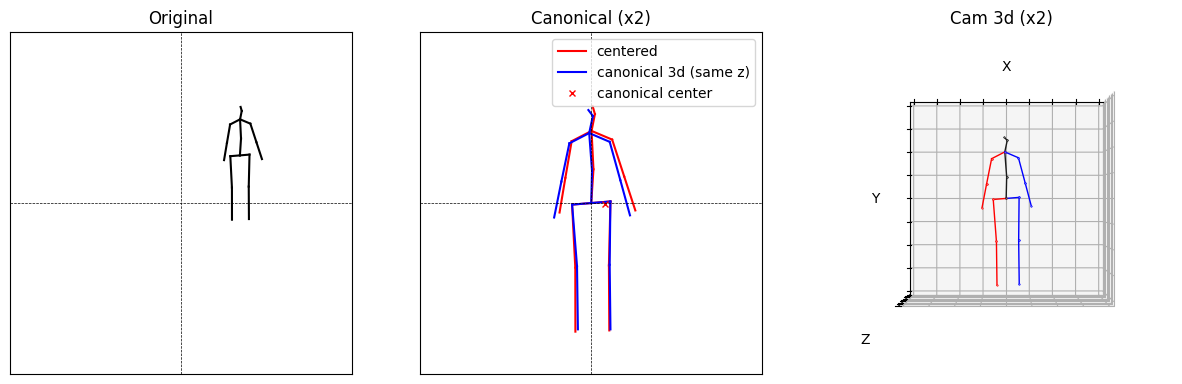

In [28]:
%matplotlib inline
fig = plt.figure(1, figsize=(15, 5))
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABC
    """,
    per_subplot_kw={('C'): {'projection': '3d'}}
)

axA = axes_2d(ax=axd['A'], normalize=True, show_axis=False)
axB = axes_2d(ax=axd['B'], normalize=True, show_axis=False)
axC = axes_3d(ax=axd['C'], show_axis=False, view=(-90, -90))

axA.set_title('Original')
axB.set_title('Canonical (x2)')
axC.set_title('Cam 3d (x2)')


load_folder = '/home/hrai/codes/MotionBERT/data/motion3d/h36m_gt_pkl'

subject_list = ['S1']

sizeup = 2

for item in glob(load_folder + '/*.pkl'):
    print(item)
    subject, camera_id, action = item.split('/')[-1].split('.')[0].split('_')
    print(subject, action, camera_id)
    if subject not in subject_list:
        continue
    data = readpkl(item)
    
    cam_param = data['cam_param'][0].reshape(1)[0].copy()
    int_mat = cam_param['intrinsic']
    ext_mat = cam_param['extrinsic']
    cam_proj = int_mat @ ext_mat
    R = ext_mat[:3, :3]
    t = ext_mat[:3, 3]
    C = T_to_C(R, t)
    num_frames = len(data['world_3d'])
    world_3d_list = np.array(data['world_3d']).copy() # (F, J, 3)
    cam_3d_list = np.array(data['cam_3d']).copy()/1000 # (F, J, 3)
    cam_3d_hat_list = get_rootrel_pose(cam_3d_list)
    world_3d_from_canonical_3d_list = get_canonical_3d_same_z(world_3d_list, cam_3d_list, C, R)
    
    videowriter = imageio.get_writer(f'/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_input_type_{subject}_{action}_{camera_id}.mp4', fps=6)
    for frame_num in tqdm(range(0, num_frames, 5)):
        pos = world_3d_from_canonical_3d_list[frame_num].copy()
        cam_3d_from_canonical_3d = World2CameraCoordinate(pos, cam_param['extrinsic']) 
        img_2d_from_canonical_3d = cam_3d_from_canonical_3d @ int_mat.T
        img_2d_from_canonical_3d /= img_2d_from_canonical_3d[:, 2:]
        img_2d = cam_3d_list[frame_num] @ int_mat.T
        img_2d /= img_2d[:, 2:]
        #img_2d_centered = img_2d - img_2d[0] + 
        
        img_2d_norm = normalize_input(img_2d, 1000, 1000)
        img_2d_centered_norm = img_2d_norm - img_2d_norm[0]
        img_2d_from_canonical_3d_norm = normalize_input(img_2d_from_canonical_3d, 1000, 1000)
        canonical_center = img_2d_from_canonical_3d_norm[0]
        img_2d_from_canonical_3d_norm = img_2d_from_canonical_3d_norm - img_2d_from_canonical_3d_norm[0]
        
        clear_axes([axA, axB, axC])
        draw_2d_pose(axA, img_2d_norm, normalize=True, color='k')
        axA.axhline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
        axA.axvline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
        draw_2d_pose(axB, img_2d_centered_norm*sizeup, normalize=True, color='r', label='centered')
        draw_2d_pose(axB, img_2d_from_canonical_3d_norm*sizeup, normalize=True, color='b', label='canonical 3d (same z)')
        axB.plot(canonical_center[0]*sizeup, canonical_center[1]*sizeup, 'rx', markersize=5, label='canonical center')
        axB.axhline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
        axB.axvline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
        draw_3d_pose(axC, cam_3d_hat_list[frame_num]*sizeup)
        
        handles, labels = axB.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        leg = axB.legend(by_label.values(), by_label.keys())
         
        canvas = FigureCanvas(fig)
        canvas.draw()
        image_from_plot = np.array(canvas.renderer._renderer)
        image_from_plot = cv2.cvtColor(image_from_plot, cv2.COLOR_RGB2BGR)       
        videowriter.append_data(image_from_plot)
        
    videowriter.close()
    #break

fit3d_gt_pkl


100%|██████████| 1504/1504 [00:00<00:00, 82551.21it/s]


/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/fit3d_gt_pkl/s11/compare_input_type_s11_side_lateral_raise_60457274.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/fit3d_gt_pkl/s07/compare_input_type_s07_barbell_shrug_60457274.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/fit3d_gt_pkl/s09/compare_input_type_s09_mule_kick_50591643.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/fit3d_gt_pkl/s08/compare_input_type_s08_warmup_5_65906101.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/fit3d_gt_pkl/s09/compare_input_type_s09_warmup_14_65906101.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/fit3d_gt_pkl/s07/compare_input_type_s07_warmup_6_50591643.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/fit3d_gt_pkl/s05/compare_input_type_s0

  0%|          | 0/836 [00:00<?, ?it/s]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Walking_54138969.mp4 already exists


[S11_Waiting_58860488]:   0%|          | 4/836 [00:09<33:52,  2.44s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Directions_58860488.mp4 already exists


[S5_WalkTogether_55011271]:   1%|          | 9/836 [00:25<50:24,  3.66s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Phoning_58860488.mp4 already exists


[S11_Sitting 1_58860488]:   2%|▏         | 15/836 [00:40<40:44,  2.98s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Smoking_58860488.mp4 already exists


[S5_Discussion 2_58860488]:   2%|▏         | 18/836 [00:52<53:16,  3.91s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Sitting 2_58860488.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_SittingDown 2_58860488.mp4 already exists


[S9_Directions_54138969]:   3%|▎         | 23/836 [01:02<38:12,  2.82s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Walking 1_60457274.mp4 already exists


[S7_WalkTogether_55011271]:   4%|▍         | 33/836 [01:33<46:48,  3.50s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkDog 1_55011271.mp4 already exists


[S6_Waiting 3_58860488]:   4%|▍         | 35/836 [01:37<35:24,  2.65s/it]   

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Discussion_58860488.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Purchases_55011271.mp4 already exists


[S8_Phoning 1_58860488]:   5%|▍         | 40/836 [01:50<39:24,  2.97s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Sitting 2_55011271.mp4 already exists


[S8_Waiting_55011271]:   5%|▌         | 42/836 [01:52<30:45,  2.32s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Photo_55011271.mp4 already exists


[S5_Discussion 2_54138969]:   8%|▊         | 63/836 [03:08<1:00:23,  4.69s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Phoning 1_60457274.mp4 already exists


[S8_Directions 1_55011271]:   8%|▊         | 65/836 [03:11<41:49,  3.25s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Sitting 1_54138969.mp4 already exists


[S8_Directions_58860488]:   8%|▊         | 67/836 [03:14<32:31,  2.54s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Posing 1_54138969.mp4 already exists


[S8_Waiting_54138969]:   9%|▉         | 79/836 [03:59<47:01,  3.73s/it]       

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkTogether 1_55011271.mp4 already exists


[S9_Directions 1_54138969]:  10%|▉         | 83/836 [04:10<39:31,  3.15s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Posing 1_55011271.mp4 already exists


[S6_Photo_54138969]:  10%|█         | 85/836 [04:12<29:22,  2.35s/it]       

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Photo_58860488.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkDog 1_54138969.mp4 already exists


[S8_Posing 1_60457274]:  11%|█         | 88/836 [04:15<21:29,  1.72s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Smoking 1_58860488.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Greeting 1_58860488.mp4 already exists


[S6_Smoking_60457274]:  11%|█▏        | 95/836 [04:37<41:14,  3.34s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Walking_58860488.mp4 already exists


[S11_Purchases_60457274]:  15%|█▍        | 122/836 [06:18<32:52,  2.76s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Smoking 1_55011271.mp4 already exists


[S6_Sitting 2_60457274]:  15%|█▌        | 126/836 [06:28<33:44,  2.85s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Photo 1_55011271.mp4 already exists


[S7_Directions 1_54138969]:  16%|█▌        | 134/836 [06:56<44:21,  3.79s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Purchases 1_58860488.mp4 already exists


[S9_WalkDog 1_60457274]:  17%|█▋        | 141/836 [07:18<40:11,  3.47s/it]   

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Phoning_54138969.mp4 already exists


[S7_Sitting_58860488]:  17%|█▋        | 145/836 [07:29<35:49,  3.11s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Discussion_55011271.mp4 already exists


[S8_Smoking 1_58860488]:  19%|█▉        | 161/836 [08:16<39:02,  3.47s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Greeting_55011271.mp4 already exists


[S9_SittingDown_60457274]:  21%|██▏       | 178/836 [09:14<45:04,  4.11s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Purchases_58860488.mp4 already exists


[S8_Smoking 1_54138969]:  22%|██▏       | 180/836 [09:18<34:14,  3.13s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Smoking_60457274.mp4 already exists


[S7_Directions 1_58860488]:  24%|██▍       | 199/836 [10:32<39:46,  3.75s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_SittingDown_55011271.mp4 already exists


[S6_Waiting 3_55011271]:  25%|██▍       | 207/836 [10:56<31:09,  2.97s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Walking 1_58860488.mp4 already exists


[S8_Greeting 1_54138969]:  25%|██▌       | 213/836 [11:08<24:12,  2.33s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Waiting 1_60457274.mp4 already exists


[S8_Walking 1_58860488]:  26%|██▌       | 216/836 [11:16<27:20,  2.65s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkTogether_54138969.mp4 already exists


[S6_Sitting 2_58860488]:  26%|██▌       | 219/836 [11:26<30:19,  2.95s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkTogether 1_58860488.mp4 already exists


[S11_Photo_55011271]:  27%|██▋       | 229/836 [11:53<31:29,  3.11s/it]       

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Directions_54138969.mp4 already exists


[S5_Directions 2_55011271]:  28%|██▊       | 231/836 [11:57<25:02,  2.48s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Directions 1_55011271.mp4 already exists


[S5_Phoning_55011271]:  28%|██▊       | 235/836 [12:05<22:57,  2.29s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_SittingDown 2_55011271.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Eating_54138969.mp4 already exists


[S8_Sitting 1_58860488]:  30%|███       | 251/836 [12:55<36:43,  3.77s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Eating_60457274.mp4 already exists


[S9_Phoning_55011271]:  31%|███       | 257/836 [13:12<32:42,  3.39s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Photo_54138969.mp4 already exists


[S7_Posing 1_54138969]:  31%|███       | 261/836 [13:23<30:28,  3.18s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Waiting 1_55011271.mp4 already exists


[S5_Eating 1_54138969]:  32%|███▏      | 264/836 [13:32<30:04,  3.15s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Directions 1_58860488.mp4 already exists


[S9_Phoning_60457274]:  32%|███▏      | 268/836 [13:43<29:53,  3.16s/it]   

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Posing_54138969.mp4 already exists


[S7_SittingDown_60457274]:  33%|███▎      | 272/836 [13:58<36:11,  3.85s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Purchases 1_60457274.mp4 already exists


[S7_WalkTogether_60457274]:  35%|███▍      | 289/836 [14:52<33:54,  3.72s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Phoning_55011271.mp4 already exists


[S8_Walking_60457274]:  36%|███▌      | 298/836 [15:24<34:06,  3.80s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Phoning 1_55011271.mp4 already exists


[S9_Phoning 1_60457274]:  36%|███▌      | 302/836 [15:37<34:08,  3.84s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Discussion 1_54138969.mp4 already exists


[S11_Sitting_58860488]:  36%|███▋      | 305/836 [15:44<26:57,  3.05s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Photo 1_58860488.mp4 already exists


[S9_Phoning 1_54138969]:  37%|███▋      | 309/836 [15:54<26:50,  3.06s/it]   

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Greeting 1_54138969.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Greeting 1_60457274.mp4 already exists


[S7_Purchases 1_54138969]:  39%|███▊      | 322/836 [16:44<31:20,  3.66s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Sitting 1_55011271.mp4 already exists


[S5_Photo 2_60457274]:  40%|████      | 336/836 [17:29<34:37,  4.16s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Eating_58860488.mp4 already exists


[S11_Discussion 1_55011271]:  40%|████      | 338/836 [17:34<26:35,  3.20s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Discussion_60457274.mp4 already exists


[S7_Eating 1_58860488]:  41%|████      | 343/836 [17:52<31:24,  3.82s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Greeting 1_55011271.mp4 already exists


[S7_WalkDog_60457274]:  41%|████▏     | 345/836 [17:56<24:45,  3.03s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Sitting 2_60457274.mp4 already exists


[S9_SittingDown_54138969]:  42%|████▏     | 351/836 [18:18<32:35,  4.03s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Purchases 1_55011271.mp4 already exists


[S8_Purchases_54138969]:  45%|████▍     | 373/836 [19:47<24:41,  3.20s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkDog 1_60457274.mp4 already exists


[S9_SittingDown_58860488]:  46%|████▌     | 382/836 [20:16<28:23,  3.75s/it]   

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Posing 1_58860488.mp4 already exists


[S11_Waiting 1_58860488]:  47%|████▋     | 392/836 [20:51<25:54,  3.50s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Smoking_54138969.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Purchases_54138969.mp4 already exists


[S8_Phoning 1_55011271]:  48%|████▊     | 401/836 [21:20<27:55,  3.85s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Sitting 2_54138969.mp4 already exists


[S8_Discussion 1_55011271]:  49%|████▊     | 406/836 [21:33<22:05,  3.08s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Greeting_54138969.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkDog 1_58860488.mp4 already exists


[S5_Walking_55011271]:  50%|████▉     | 416/836 [22:06<29:10,  4.17s/it]       

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Smoking_55011271.mp4 already exists


[S7_Photo 1_58860488]:  50%|█████     | 418/836 [22:09<20:20,  2.92s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Purchases_60457274.mp4 already exists


[S5_Discussion 2_60457274]:  51%|█████     | 425/836 [22:40<33:06,  4.83s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Phoning_60457274.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Waiting 1_54138969.mp4 already exists


[S9_Eating 1_54138969]:  51%|█████▏    | 429/836 [22:48<21:59,  3.24s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Photo 1_54138969.mp4 already exists


[S7_Greeting 1_54138969]:  52%|█████▏    | 431/836 [22:51<17:41,  2.62s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Discussion 1_55011271.mp4 already exists


[S8_Sitting_58860488]:  52%|█████▏    | 437/836 [23:15<23:58,  3.61s/it]       

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Posing_58860488.mp4 already exists


[S8_Sitting_54138969]:  54%|█████▍    | 452/836 [24:11<24:22,  3.81s/it]       

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Phoning 1_54138969.mp4 already exists


[S5_Purchases 1_55011271]:  56%|█████▌    | 468/836 [25:07<25:35,  4.17s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_SittingDown_58860488.mp4 already exists


[S7_Eating 1_55011271]:  59%|█████▉    | 496/836 [27:07<25:39,  4.53s/it]       

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Posing 1_60457274.mp4 already exists


[S5_SittingDown_55011271]:  60%|██████    | 502/836 [27:32<28:49,  5.18s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Walking_60457274.mp4 already exists


[S5_WalkTogether_54138969]:  61%|██████    | 511/836 [28:06<21:12,  3.92s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkTogether 1_60457274.mp4 already exists


[S9_Sitting 1_54138969]:  65%|██████▍   | 540/836 [29:49<18:17,  3.71s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Waiting_55011271.mp4 already exists


[S7_Directions_60457274]:  66%|██████▌   | 550/836 [30:20<17:32,  3.68s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Directions_60457274.mp4 already exists


[S6_WalkDog 1_58860488]:  67%|██████▋   | 558/836 [30:48<16:39,  3.59s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Directions 1_54138969.mp4 already exists


[S11_Smoking 2_54138969]:  68%|██████▊   | 565/836 [31:10<16:31,  3.66s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkTogether_58860488.mp4 already exists


[S5_Waiting 2_54138969]:  68%|██████▊   | 572/836 [31:34<18:19,  4.17s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Photo 1_60457274.mp4 already exists


[S11_Discussion 1_60457274]:  69%|██████▊   | 574/836 [31:39<14:12,  3.25s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Eating 2_54138969.mp4 already exists


[S9_Smoking_55011271]:  69%|██████▉   | 578/836 [31:50<14:28,  3.37s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkTogether_55011271.mp4 already exists


[S9_WalkDog_58860488]:  69%|██████▉   | 580/836 [31:53<11:35,  2.72s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Posing_60457274.mp4 already exists


[S6_Sitting 1_60457274]:  70%|██████▉   | 585/836 [32:04<10:17,  2.46s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Eating 2_55011271.mp4 already exists


[S5_Sitting_54138969]:  71%|███████   | 591/836 [32:22<13:24,  3.28s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Smoking 1_54138969.mp4 already exists


[S11_Waiting 1_54138969]:  71%|███████   | 595/836 [32:31<10:59,  2.74s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_SittingDown_54138969.mp4 already exists


[S5_Posing 1_54138969]:  72%|███████▏  | 599/836 [32:40<10:12,  2.59s/it]   

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Sitting 1_60457274.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Discussion 1_58860488.mp4 already exists


[S5_WalkDog_54138969]:  74%|███████▎  | 616/836 [33:33<12:07,  3.30s/it]       

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkTogether 1_54138969.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Sitting 1_58860488.mp4 already exists


[S7_Purchases 1_58860488]:  77%|███████▋  | 640/836 [34:59<14:27,  4.42s/it]   

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Walking 1_55011271.mp4 already exists


[S8_Waiting 1_60457274]:  77%|███████▋  | 643/836 [35:06<10:25,  3.24s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Purchases 1_54138969.mp4 already exists


[S8_Directions_55011271]:  77%|███████▋  | 647/836 [35:17<09:26,  3.00s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Photo_60457274.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Eating_55011271.mp4 already exists


[S6_Directions 1_54138969]:  78%|███████▊  | 651/836 [35:25<08:04,  2.62s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkTogether_60457274.mp4 already exists


[S5_Directions 2_60457274]:  79%|███████▊  | 657/836 [35:44<09:12,  3.09s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Waiting_60457274.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Eating 2_58860488.mp4 already exists


[S6_Phoning_60457274]:  79%|███████▉  | 661/836 [35:49<06:21,  2.18s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Discussion 1_60457274.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Waiting_54138969.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Waiting 1_58860488.mp4 already exists


[S9_Waiting 1_54138969]:  81%|████████  | 674/836 [36:31<08:42,  3.23s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Phoning 1_58860488.mp4 already exists


[S11_Eating_55011271]:  81%|████████  | 679/836 [36:55<12:14,  4.68s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_SittingDown 2_54138969.mp4 already exists


[S9_WalkTogether_55011271]:  83%|████████▎ | 695/836 [37:58<08:39,  3.68s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_SittingDown_60457274.mp4 already exists


[S6_Waiting_54138969]:  84%|████████▍ | 702/836 [38:23<08:17,  3.71s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkDog_60457274.mp4 already exists


[S7_WalkDog 1_54138969]:  87%|████████▋ | 724/836 [39:36<06:09,  3.30s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Posing_55011271.mp4 already exists


[S5_Posing 1_58860488]:  89%|████████▊ | 740/836 [40:33<05:38,  3.52s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Waiting_58860488.mp4 already exists
/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Greeting_60457274.mp4 already exists


[S8_WalkDog_58860488]:  90%|█████████ | 753/836 [41:08<04:24,  3.19s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Discussion_54138969.mp4 already exists


[S6_Greeting 1_55011271]:  91%|█████████ | 757/836 [41:18<03:37,  2.75s/it]  

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Eating 2_60457274.mp4 already exists


[S7_SittingDown 1_55011271]:  93%|█████████▎| 776/836 [42:26<04:52,  4.87s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Smoking 1_60457274.mp4 already exists


[S11_WalkTogether_58860488]:  94%|█████████▎| 783/836 [42:45<02:37,  2.96s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkDog_58860488.mp4 already exists


[S5_Directions 2_54138969]:  95%|█████████▌| 797/836 [43:34<02:18,  3.56s/it] 

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Walking_55011271.mp4 already exists


[S9_Posing_54138969]:  96%|█████████▌| 801/836 [43:48<01:55,  3.31s/it]      

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Directions_55011271.mp4 already exists


[S5_Smoking 1_60457274]:  96%|█████████▌| 803/836 [43:52<01:36,  2.92s/it]

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Walking 1_54138969.mp4 already exists


[S6_Purchases_55011271]:  96%|█████████▋| 806/836 [43:57<01:09,  2.31s/it]   

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_SittingDown 2_60457274.mp4 already exists


[S7_Posing 1_55011271]:  97%|█████████▋| 814/836 [44:36<01:47,  4.88s/it]     

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkDog_55011271.mp4 already exists


[S5_Posing_54138969]:  98%|█████████▊| 820/836 [44:52<00:51,  3.21s/it]    

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_WalkDog_54138969.mp4 already exists


[S9_Sitting_60457274]:  99%|█████████▉| 830/836 [45:29<00:25,  4.33s/it]       

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Directions 1_60457274.mp4 already exists


[S6_Waiting_55011271]: 100%|██████████| 836/836 [45:42<00:00,  3.28s/it]        

/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/h36m_gt_pkl/S1/compare_input_type_S1_Greeting_58860488.mp4 already exists


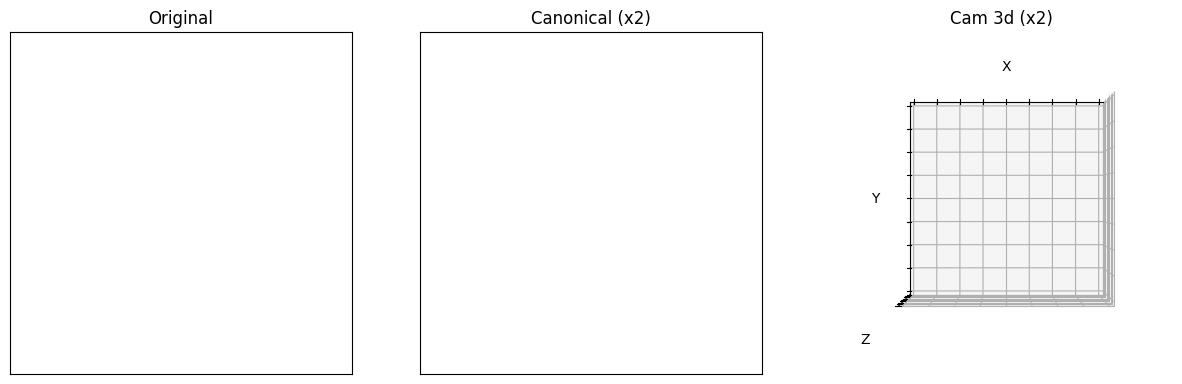

In [4]:
import concurrent.futures

%matplotlib inline
fig = plt.figure(1, figsize=(15, 5))
fig.clear()
axd = fig.subplot_mosaic(
    """
    ABC
    """,
    per_subplot_kw={('C'): {'projection': '3d'}}
)

axA = axes_2d(ax=axd['A'], normalize=True, show_axis=False)
axB = axes_2d(ax=axd['B'], normalize=True, show_axis=False)
axC = axes_3d(ax=axd['C'], show_axis=False, view=(-90, -90))

axA.set_title('Original')
axB.set_title('Canonical (x2)')
axC.set_title('Cam 3d (x2)')

def plot_frame(frame_num):
    pos = world_3d_from_canonical_3d_list[frame_num].copy()
    cam_3d_from_canonical_3d = World2CameraCoordinate(pos, cam_param['extrinsic']) 
    img_2d_from_canonical_3d = cam_3d_from_canonical_3d @ int_mat.T
    img_2d_from_canonical_3d /= img_2d_from_canonical_3d[:, 2:]
    img_2d = cam_3d_list[frame_num] @ int_mat.T
    img_2d /= img_2d[:, 2:]
    #img_2d_centered = img_2d - img_2d[0] + 
    
    img_2d_norm = normalize_input(img_2d, 1000, 1000)
    img_2d_centered_norm = img_2d_norm - img_2d_norm[0]
    img_2d_from_canonical_3d_norm = normalize_input(img_2d_from_canonical_3d, 1000, 1000)
    canonical_center = img_2d_from_canonical_3d_norm[0]
    img_2d_from_canonical_3d_norm = img_2d_from_canonical_3d_norm - img_2d_from_canonical_3d_norm[0]
    
    clear_axes([axA, axB, axC])
    draw_2d_pose(axA, img_2d_norm, normalize=True, color='k')
    axA.axhline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
    axA.axvline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
    draw_2d_pose(axB, img_2d_centered_norm*sizeup, normalize=True, color='r', label='centered')
    draw_2d_pose(axB, img_2d_from_canonical_3d_norm*sizeup, normalize=True, color='b', label='canonical 3d (same z)')
    axB.plot(canonical_center[0]*sizeup, canonical_center[1]*sizeup, 'rx', markersize=5, label='canonical center')
    axB.axhline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
    axB.axvline(0, 0, 1, color='k', linestyle='--', linewidth=0.5)
    draw_3d_pose(axC, cam_3d_hat_list[frame_num]*sizeup)
    
    handles, labels = axB.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    leg = axB.legend(by_label.values(), by_label.keys())
    
    # 이미지를 메모리에 저장
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    
    #plt.close(fig)  # 메모리 누수 방지
    return image


for dataset in ['fit3d_gt_pkl', 'h36m_gt_pkl']:
    print(dataset)
    load_folder = f'/home/hrai/codes/MotionBERT/data/motion3d/{dataset}'

    #subject_list = ['s03']
    sizeup = 1.5

    pbar = tqdm(glob(load_folder + '/*.pkl'))
    for item in pbar:
        #print(item)
        splited = item.split('/')[-1].split('.')[0].split('_')
        subject = splited[0]
        cam_id = splited[1]
        if 'fit3d_gt_pkl' == dataset: 
            action = '_'.join(splited[2:])
        elif 'h36m_gt_pkl' == dataset:
            action = splited[2]
        
        #print(subject, action, cam_id)    
        #if subject not in subject_list: continue
        
        folder = f'/home/hrai/codes/MotionBERT/custom_codes/Canonical/compare_canonical/{dataset}/{subject}'
        if not os.path.exists(folder): os.makedirs(folder)
        filename = os.path.join(folder, f'compare_input_type_{subject}_{action}_{cam_id}.mp4') 
        if os.path.exists(filename): 
            print(f'{filename} already exists')
            continue
        
        data = readpkl(item)
        
        cam_param = data['cam_param'][0].reshape(1)[0].copy()
        int_mat = cam_param['intrinsic']
        ext_mat = cam_param['extrinsic']
        cam_proj = int_mat @ ext_mat
        R = ext_mat[:3, :3]
        t = ext_mat[:3, 3]
        C = T_to_C(R, t)
        num_frames = len(data['world_3d'])
        world_3d_list = np.array(data['world_3d']).copy() # (F, J, 3)
        cam_3d_list = np.array(data['cam_3d']).copy()/1000 # (F, J, 3)
        cam_3d_hat_list = get_rootrel_pose(cam_3d_list)
        world_3d_from_canonical_3d_list = get_canonical_3d_same_z(world_3d_list, cam_3d_list, C, R)
        
        
        with imageio.get_writer(filename, fps=6, macro_block_size=1) as writer:
            with concurrent.futures.ProcessPoolExecutor() as executor:
                for image in executor.map(plot_frame, range(0, num_frames, 5)):
                    writer.append_data(image)
            
        pbar.set_description(f'[{subject}_{action}_{cam_id}]')


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import concurrent.futures

def plot_frame(i):
    fig, ax = plt.subplots()
    t = np.linspace(0, 2*np.pi, 100)
    ax.plot(t, np.sin(t + i * 0.1))  # 예시로 sine 파형을 그리고 있음
    ax.set_title(f'Frame {i}')
    
    # 이미지를 메모리에 저장
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    
    plt.close(fig)  # 메모리 누수 방지
    return image

def create_video(num_frames, filename='output.mp4'):
    with imageio.get_writer(filename, fps=30) as writer:
        with concurrent.futures.ProcessPoolExecutor() as executor:
            # 각 프레임을 병렬적으로 처리
            for image in executor.map(plot_frame, range(num_frames)):
                writer.append_data(image)

if __name__ == '__main__':
    create_video(100)  # 100 프레임짜리 비디오 생성


In [1]:
pwd

'/home/hrai/codes/MotionBERT/custom_codes/Canonical'

In [16]:
batch_num = -1
videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/Canonical/canonical_test{}.mp4'.format(batch_num), fps=30)
for i in range(243):
    img = get_2d_pose_image(batch_input_denormalized_with_canonical[batch_num, i], W=1000, H=1000)
    cv2.putText(img, str(i), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)
    videowriter.append_data(img)
videowriter.close()

videowriter = imageio.get_writer('/home/hrai/codes/MotionBERT/custom_codes/Canonical/test{}.mp4'.format(batch_num), fps=30)
for i in range(243):
    img = get_2d_pose_image(batch_input_denormalized[batch_num, i], W=1000, H=1000)
    cv2.putText(img, str(i), (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1, cv2.LINE_AA)
    videowriter.append_data(img)
videowriter.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[swscaler @ 0x617cdc0] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x73addc0] Warning: data is not aligned! This can lead to a speed loss
